In [3]:
import sys
if "../" not in sys.path:  # to get my usual helpers at base dir
    sys.path.append("../") 

import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
from lightkurve_ext import TransitTimeSpec, TransitTimeSpecList
import lightkurve_ext_tess as lket
import lightkurve_ext_pg as lke_pg
import lightkurve_ext_pg_runner as lke_pg_runner
import tic_plot as tplt

import asyncio_compat

import math
import re
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

from importlib import reload # useful during development to reload packages

from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7


# No longer works in Jupyter 7+
display(Javascript("""
// export notebook url to Python for bokeh-based interactive features
if (window["IPython"] != null) {
  IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);
} else {
  console.warn("IPython js object not available (in Jupyter 7). Hardcode notebook_url in the notebook itself instead.")
}
"""));
notebook_url = "localhost:8888"

%matplotlib inline

# data cache config
lk_download_dir = '../data'
if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir

# make markdown table aligned to the left of the cell output (instead of center)
display(HTML("<style>table {margin-left: 4ch;}</style>"))

<IPython.core.display.Javascript object>

# Centroid for the variability near EPIC 210666756

VSX Entry: https://www.aavso.org/vsx/index.php?view=detail.top&oid=625480

3 stars in questions.
Star A, or EPIC 210666756, is the one identified in VSX, with ready lightcurves from K2 and TESS: 

| Star | K2             | TESS          | Gaia                       | GMag | Separation |
| ---- | -------------- | ------------- | -------------------------- | ---- | ---------- |
| A    | EPIC 210666756 | TIC 242942524 | Gaia DR3 49835540624946304 | 12.9 | 0"         |
| B    |                | TIC 640392006 | Gaia DR3 49835540624946304 | 15.3 | 2.4"       |
| C    |                | TIC 242942527 | Gaia DR3 49835540624946176 | 14.9 | 8.0"   |    |

## Centroid Offset Analysis from K2

Vetting result the in-eclipse centroid is near star C.
- report at: https://keplertcert.seti.org/DAVE/K2/Output/210666756/
- the [record](https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ65714c8e2e2349&-out.add=.&-source=J/AJ/157/124/table2&recno=5) from 2019AJ....157..124K


Left: Annotated result for brevity; Right: the original plot from Vetting report section [Centroid 1 Plots](https://keplertcert.seti.org/DAVE/K2/Output/210666756/#:~:text=Centroid%201%20Plots):

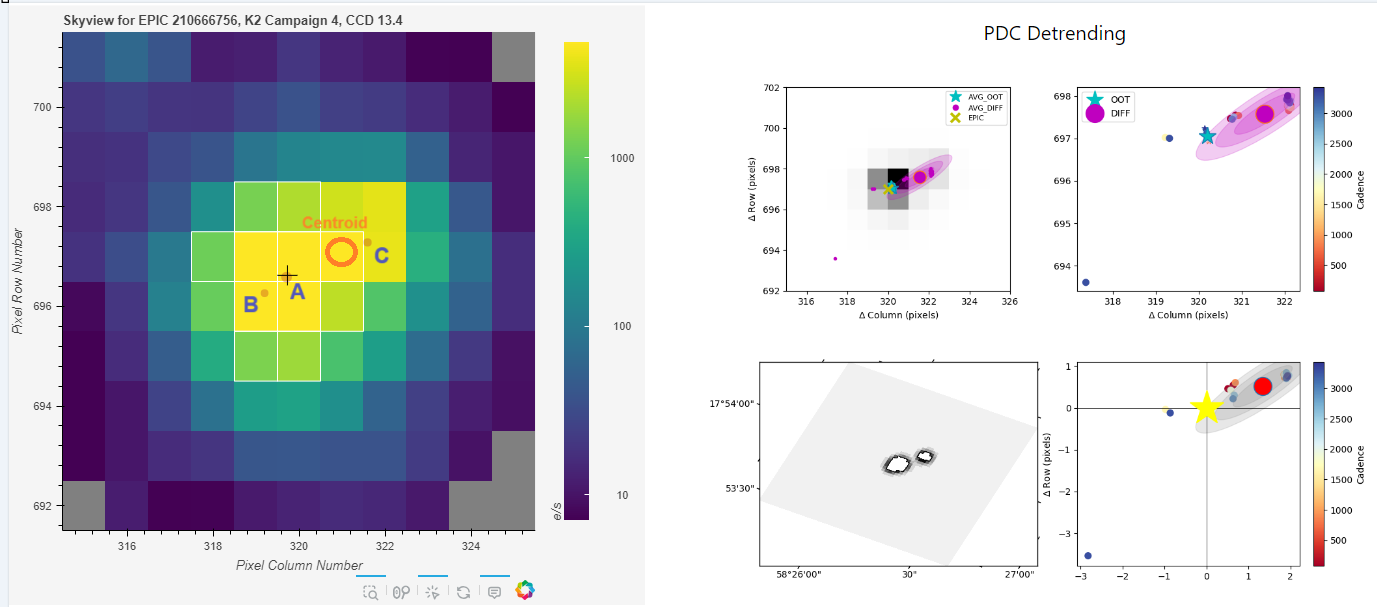



## Centroid Offset Analysis from TESS

TESS TCEs suggest similar offset, e.g. from the [TCE for sectors 42 - 44](https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:TESS/product/tess2021233042500-s0042-s0046-0000000242942524-00550_dvm.pdf), i.e., 2021 Aug 20 to Nov 06.

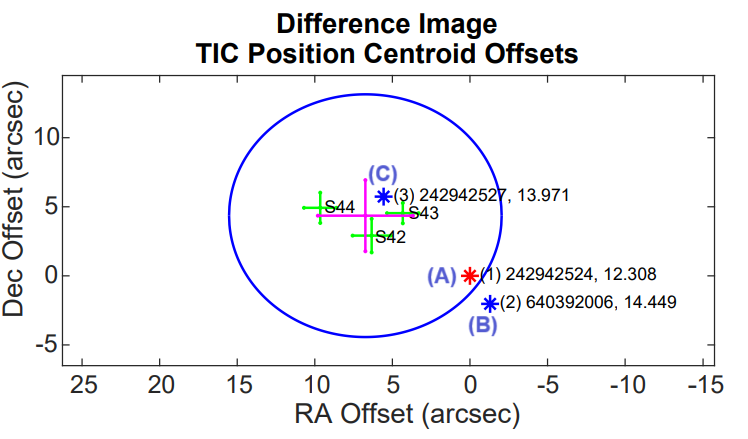


The TCE for more recent data suggests similar offset
- [TCE for sector 70](https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:TESS/product/tess2023263202030-s0070-s0070-0000000242942524-00809_dvm.pdf), 2023 Sep 20 to Oct 16
- [TCE for sector 71](https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:TESS/product/tess2023289124029-s0071-s0071-0000000242942524-00816_dvm.pdf), 2023 Oct 16 to Nov 11

TESS Sector observation date for reference:  https://heasarc.gsfc.nasa.gov/docs/tess/sector.html

## Folded Lightcurve from ZTF DR19

### filter `zr`:

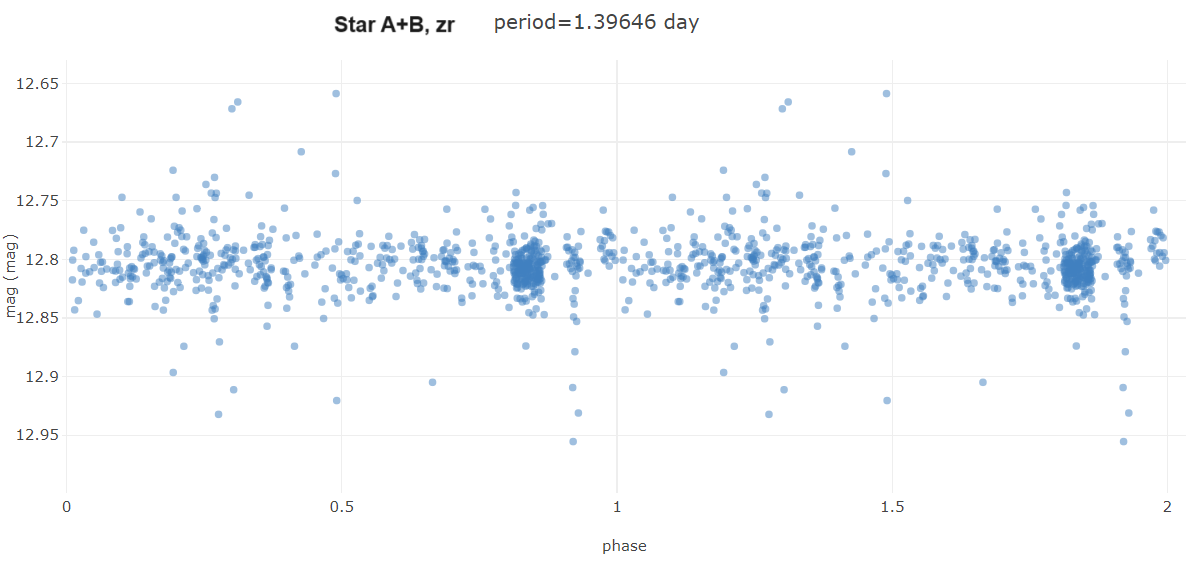

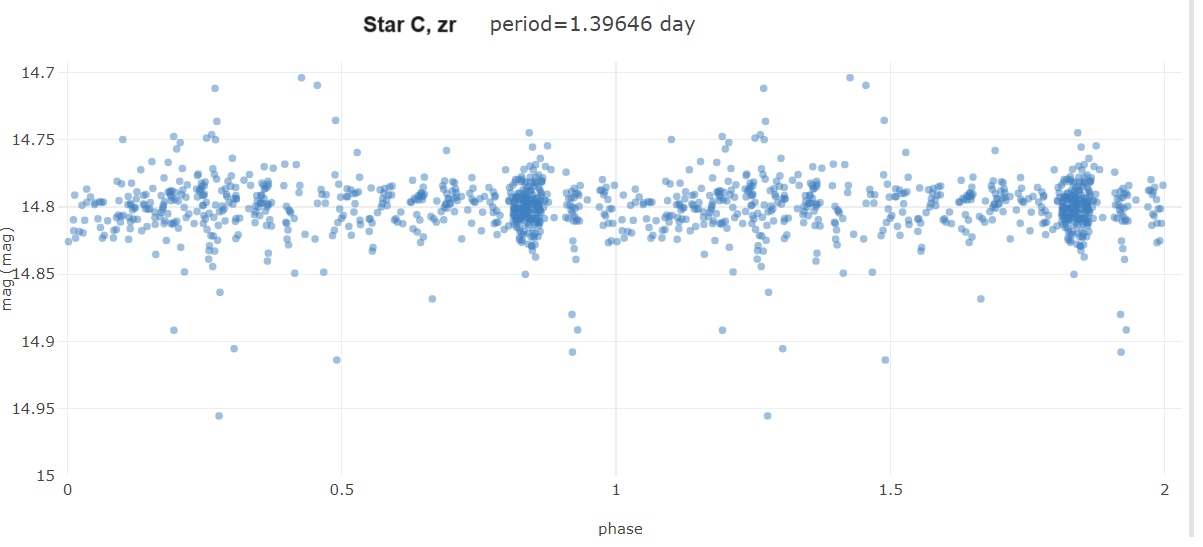


From: https://irsa.ipac.caltech.edu/workspace/TMP_PiFO0k_3602/Gator/irsa/7870/tbview.html
- Star A+B: oid 558207400000778
- Star C: oid 558207400000756


### filter `zg`:

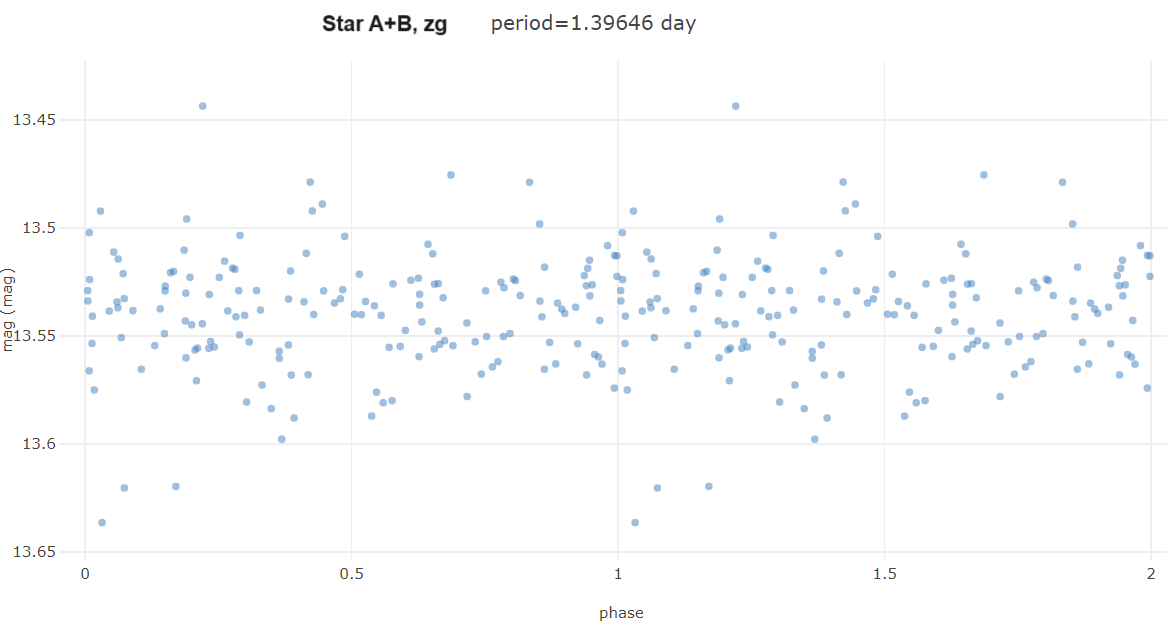

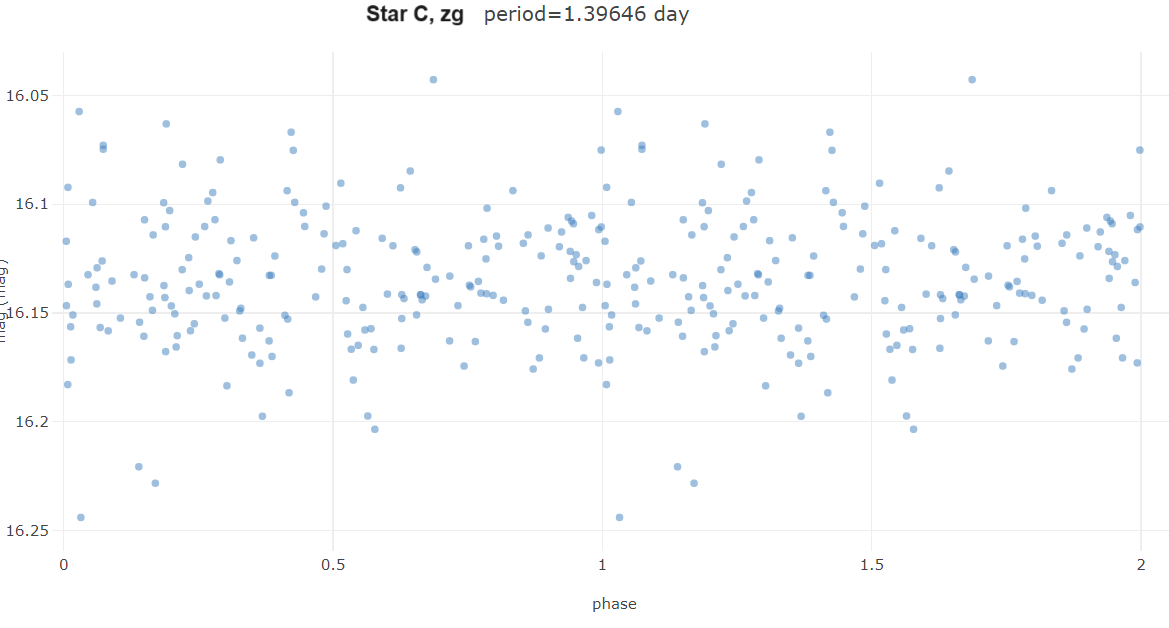


From: https://irsa.ipac.caltech.edu/workspace/TMP_PiFO0k_3602/Gator/irsa/7870/tbview.html
- Star A+B: oid 558107400000383
- Star C: oid 558107400000374


---

## Appendix: K2 Data

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,K2 Campaign 04,2015,K2,1800,ktwo210666756,0.0,GO4007_GO4029_GO4033
1,K2 Campaign 04,2015,EVEREST,1800,ktwo210666756,0.0,--
2,K2 Campaign 04,2015,K2SC,1800,ktwo210666756,0.0,--
3,K2 Campaign 04,2015,K2SFF,1800,ktwo210666756,0.0,--
4,K2 Campaign 04,2015,K2VARCAT,1800,ktwo210666756,0.0,--


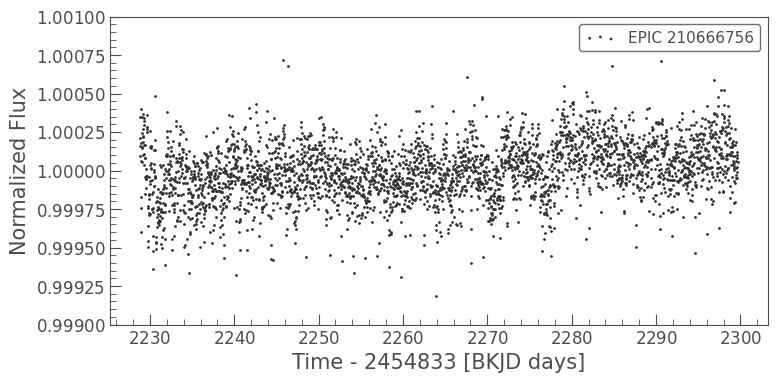

In [4]:
sr = lk.search_lightcurve("EPIC 210666756")
display(sr)

lc_k2 = sr[sr.author == "K2"].download()

ax = lc_k2.normalize().scatter();
ax.set_ylim(0.999, 1.001);

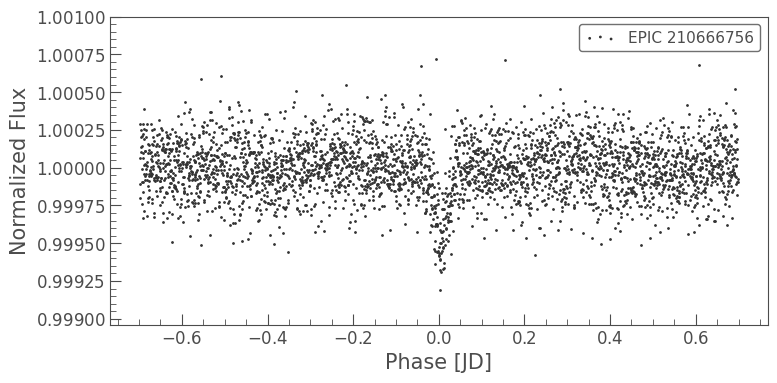

In [9]:
epoch_time_bkjd = Time(2448.5286, format="btjd").to_value("bkjd")  # epoch from s0042-s0046:TCE1 below, period from Sebatsian (based on TESS + K2)
period=1.396455
ax = lc_k2.fold(epoch_time=epoch_time_bkjd, period=period).normalize().scatter();  
ax.set_ylim(None, 1.001);

In [13]:
sr_tpf = lk.search_targetpixelfile("EPIC 210666756")
display(sr_tpf)
tpf = sr_tpf.download();

tpf.interact_sky(notebook_url=notebook_url, aperture_mask="pipeline");

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,K2 Campaign 04,2015,K2,1800,ktwo210666756,0.0,GO4007_GO4029_GO4033


C:\dev\lightkurve\src\lightkurve\interact.py:557: LightkurveWarning: interact_sky() - cannot obtain nearby TICs. Skip it. The error: not enough values to unpack (expected 3, got 2)
  warnings.warn(


Per-pixel plot also seems to suggest the centroid is near Star C.

Caveat: I don't know how much trustowrthy the per-pixel plot for K2 data though.

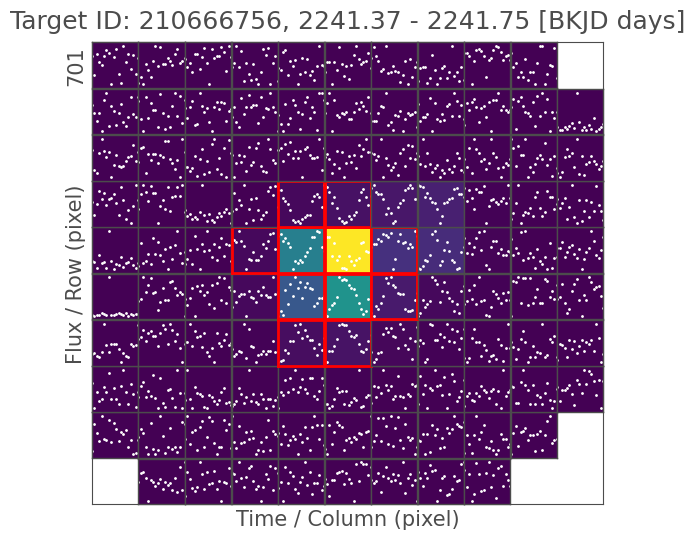

In [29]:
t0 = epoch_time_bkjd - period * 1700  # pick one of the dips in , * 1705 also looks okay
tpf_trunc = lke.truncate(tpf, t0 - 0.2, t0 + 0.2);
# ax = tpf_trunc.to_lightcurve().scatter(label=f"t0: {t0}");

pixel_size_inches, markersize = 0.6, 2
ax = tplt.lk_ax(figsize=(tpf_trunc.flux[0].shape[1] * pixel_size_inches, tpf_trunc.flux[0].shape[0] * pixel_size_inches))
tpf_trunc.plot_pixels(ax=ax, markersize=markersize, show_flux=True, aperture_mask="pipeline");

## Appendix: TESS data

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 42,2021,SPOC,120,242942524,0.0,G04242
1,TESS Sector 43,2021,SPOC,120,242942524,0.0,G04242
2,TESS Sector 44,2021,SPOC,120,242942524,0.0,G04242
3,TESS Sector 70,2023,SPOC,120,242942524,0.0,G06058
4,TESS Sector 71,2023,SPOC,120,242942524,0.0,G06058


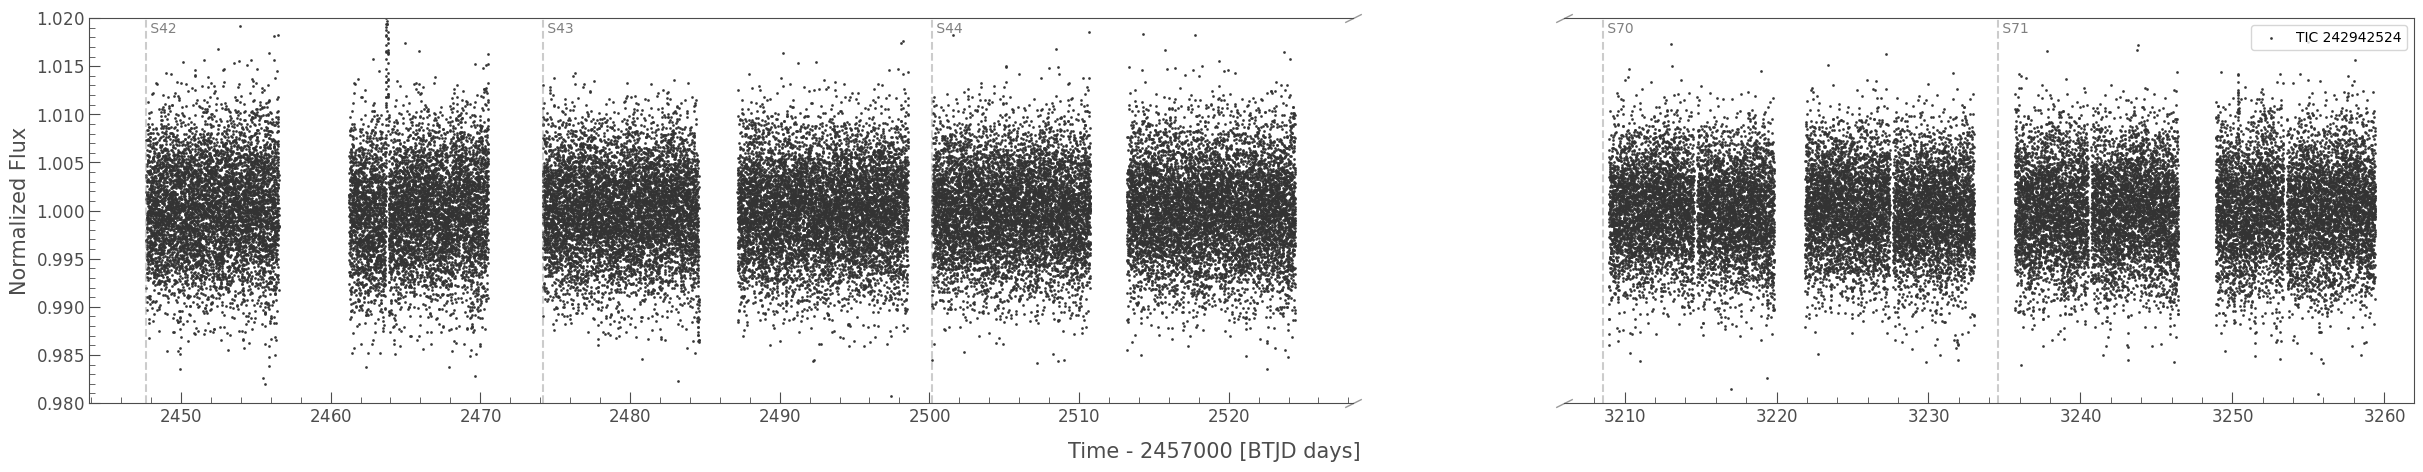

In [4]:
sr = lk.search_lightcurve("TIC242942524", cadence="short")
display(sr)

lcc_tess = sr.download_all()  # a collection of LCs

lc_tess = lke.stitch(lcc_tess, corrector_func=lambda lc: lc.normalize())
axs = tplt.plot_skip_data_gap(lc_tess, figsize=(30,5), s=4, alpha=0.9);
[ax.set_ylim(0.98, 1.02) for ax in axs];

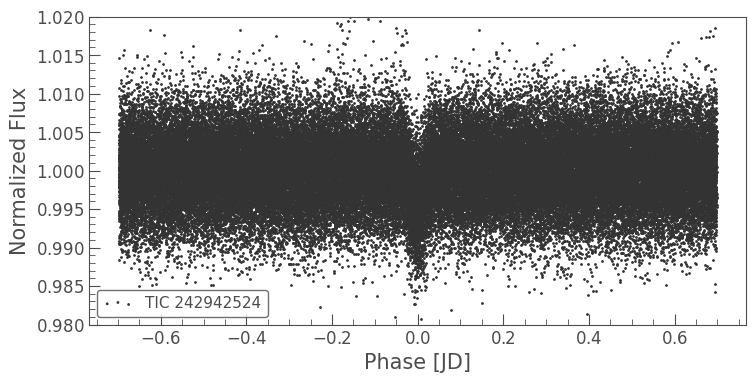

In [5]:
ax = lc_tess.fold(epoch_time=2448.5286, period=1.396455).scatter();  # epoch from s0042-s0046:TCE1 below, period from Sebatsian (based on TESS + K2)
ax.set_ylim(0.98, 1.02);

In [6]:
# Convert the epoch to MJD for ZTF plot
Time(2448.5286, format="btjd").to_value("mjd")

59448.0286

In [31]:
sr_tpf = lk.search_targetpixelfile("TIC242942524")
display(sr_tpf)
tpf = sr_tpf[0].download();

tpf.interact_sky(notebook_url=notebook_url, aperture_mask="pipeline");

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 42,2021,SPOC,120,242942524,0.0,G04242
1,TESS Sector 43,2021,SPOC,120,242942524,0.0,G04242
2,TESS Sector 44,2021,SPOC,120,242942524,0.0,G04242
3,TESS Sector 70,2023,SPOC,120,242942524,0.0,G06058
4,TESS Sector 71,2023,SPOC,120,242942524,0.0,G06058
5,TESS Sector 42,2021,TESS-SPOC,600,242942524,0.0,N/A
6,TESS Sector 43,2021,TESS-SPOC,600,242942524,0.0,N/A
7,TESS Sector 44,2021,TESS-SPOC,600,242942524,0.0,N/A


In [36]:
##  Per-pixel plot is unhelpful, as the 3 stars are pracitcaly on the same pixel.
#
# t0 = 2448.5286  # pick one of the dips in , * 1705 also looks okay
# tpf_trunc = lke.truncate(tpf, t0 - 0.2, t0 + 0.2);
# # ax = tpf_trunc.to_lightcurve().scatter(label=f"t0: {t0}");

# pixel_size_inches, markersize = 0.6, 0.4
# ax = tplt.lk_ax(figsize=(tpf_trunc.flux[0].shape[1] * pixel_size_inches, tpf_trunc.flux[0].shape[0] * pixel_size_inches))
# tpf_trunc.plot_pixels(ax=ax, markersize=markersize, show_flux=True, aperture_mask="pipeline");

### Links to TESS TCEs for centroid offset analysis

In [7]:
display(HTML(lket.get_tic_meta_in_html(lcc_tess[0], download_dir=lk_download_dir)))